В этом задании мы будем решать задачу многоклассовой классификации сначала на сгенерированных данных, а затем на датасете Digits. Вы реализуете функции активации и архитектуру нейросети, а затем примените это на датасете.

Изученные ранее классы и функции, которые нам понадобятся.

In [21]:
import numpy as np

In [22]:
class LinearLayer:
    def __init__(self, input_size, output_size, activation_function, activation_function_derivative):
        self.input_size = input_size
        self.output_size = output_size
        
        self.W = np.random.random_sample((output_size, input_size)) * 2 - 1
        self.b = np.random.random_sample((output_size,)) * 2 - 1
            
        self.grad_W = np.zeros((output_size, input_size))
        self.grad_b = np.zeros((output_size,))
        
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        
    def forward(self, x):
        z = self.W @ x + self.b # z^(l+1) = W^(l)*h^(l) + b^(l)
        h = self.activation_function(z) # h^(l) = f(z^(l))
        return h, z
    
    def backward(self, delta_next, z, w_next):
        return w_next.T @ delta_next * self.activation_function_derivative(z)

    def backward_as_last_layer(self, loss_der, z):
        return np.sum(self.activation_function_derivative(z) * loss_der, axis = 0)
    
    def clear_grad(self):
        self.grad_W = np.zeros((self.output_size, self.input_size))
        self.grad_b = np.zeros((self.output_size,))


In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1 - sigmoid(x))

Импортируем основные библиотеки:



In [24]:
import math
import numpy as np
import seaborn as sns

## SoftMax и Cross Entropy

### SoftMax и ее производная

Основной функцией активации, используемой в нашем случае, является SoftMax.

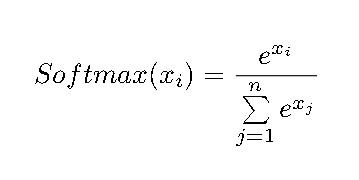

Реализуем ее. Будем возвращать сразу массив значений Softmax для вектора x.

Подсказка: очень хорошо для этого подойдёт функция np.exp().

In [6]:
def Softmax(x):
    return (np.exp(x) / np.exp(x).sum())

Также, нам понадобится производная SoftMax. Здесь мы применим один трюк — гораздо удобнее считать производные SoftMax и Cross Entropy совместно, как CE(softmax(x)). Поэтому обозначим производную за 1, чтобы не переписывать весь код нейронных сетей.

In [5]:
def Softmax_derivative(x):
    return 1

SoftMax должен сохранить относительные размеры элементов массива. То есть тот элемент, который до SoftMax был больше других, должен быть и после применения больше, а меньший элемент, соответственно, меньше.

In [7]:
test = np.array([0, 1, 10])
print(Softmax(test))

[4.53922671e-05 1.23388975e-04 9.99831219e-01]


In [8]:
print(Softmax_derivative(test))

1


### Cross Entropy Loss

Реализуем CE Loss:


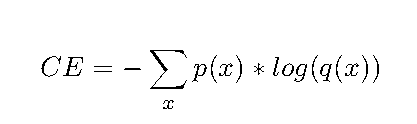

Для начала преобразуем наш target в так называемый one hot vector — 
он представляет собой вектор размера максимального количества классов, где 
каждое число отвечает за класс. То есть, например, для target=3 при общем количестве классов 5 one hot vector будет выглядеть как [0,0,0,1,0]

In [9]:
def targets_to_onehot(N_classes, targets):
    one_hot = []
    for value in range(len(targets)):
        letter = [0 for _ in range(N_classes)]
        letter[targets[value]] = 1
        one_hot.append(letter)
    return one_hot

print(targets_to_onehot(5, [1,2,4,3,0]))
print(targets_to_onehot(3, [0,1,2]))
print(targets_to_onehot(3, [1]))

#[[0. 1. 0. 0. 0.]
# [0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 1.]
# [0. 0. 0. 1. 0.]
# [1. 0. 0. 0. 0.]]

[[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0]]
[[1, 0, 0], [0, 1, 0], [0, 0, 1]]
[[0, 1, 0]]


Используем такой трюк: введем epsilon(eps) и с его помощью ограничим числа, чтобы не получить случайно 0 внутри логарифма, что приведет к Nan.

При этом выберем eps достаточно маленьким, чтобы не потерять точность.

Для ограничения чисел воспользуемся функцией np.clip(), её нужно задать верхнюю и нижние границы.

In [10]:
def CE_loss(predicts, targets):
    targets_one_hot = targets_to_onehot(len(predicts), targets)
    eps = 1e-12
    preds = np.clip(predicts, eps, 1-eps)
    N = preds.shape[0]
    return -np.sum(targets_one_hot*np.log(preds))/N

Проверьте себя, должны получиться числа как в комментариях.

In [11]:
print(CE_loss([[1,2,3], [3,2,1], [0,1,0]], [0,1,2]))
# 9.21034037197685
print(CE_loss([[1,2,3], [3,2,1], [0,1,0]], [2,0,1]))
# 9.999778782803785e-13
print(CE_loss([0.17484159, 0.32539135, 0.49976707], [0]))

9.21034037197685
9.999778782803785e-13
0.5812916383331824


###Производная CE с учетом SoftMax

Для начала нам нужно посчитать производную SoftMax.


Рассматривается два случая — производная от SM(x_i) по x_c, где c!=i и где c=i, то есть производная от SM(x_i) по x_i.

Первый случай — производная по x_c.

Ваша задача посчитать производную по x_c и выразить её через функцию SoftMax.

In [12]:
def dSoftmax_dxc(x, c, i):
    sm = Softmax(x)
    if c == i:
        return sm[i] * (1 - sm[c])
    else:
        return -sm[i] * sm[c]

In [13]:
x = [1,2,3,4,5]
print(dSoftmax_dxc(x, 1, 2))
#-0.0027289761087486435
print(dSoftmax_dxc(x, 2, 1))
#-0.0027289761087486435
print(dSoftmax_dxc(x, 3, 2))
#-0.020164557560185196
print(dSoftmax_dxc(x, 4, 3))
#-0.14899704702232458

-0.0027289761087486435
-0.0027289761087486435
-0.020164557560185196
-0.14899704702232458


Теперь посчитайте производную по x_i.

In [14]:
def dSoftmax_dxi(x, i):
    sm = Softmax(x)
    return sm[i] * (1 - sm[i])

In [15]:
x = [1,2,3,4,5]

print(dSoftmax_dxi(x, 0))
#0.01152036323593907
print(dSoftmax_dxi(x, 1))
#0.0306809865902676
print(dSoftmax_dxi(x, 2))
#0.0787104182695584
print(dSoftmax_dxi(x, 3))
#0.17930870685796874
print(dSoftmax_dxi(x, 4))
#0.23139268114398798

0.01152036323593907
0.0306809865902676
0.0787104182695584
0.17930870685796874
0.23139268114398798


Теперь перейдем к производной от Cross Entropy.

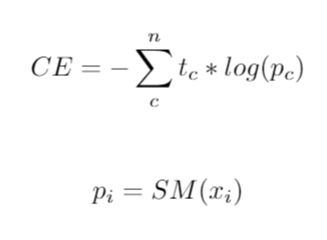

Производную кросс энтропии можно разделить на две части — та, в которой берется производная по совпадающему индексу i и сумма всех остальных, далее нужно подставить производные софтмакса, далее получится что-то вроде двух слагаемых, в одном из которых сумма по c!=i, в другом выражение с i-ым индексом

После можно заметить что часть из левого выражения можно внести под сумму и получить сумму уже по всем индексам без исключений. Также следует принять во внимание что t здесь — это тот самый one hot вектор, поэтому сумма по нему будет равна единице.

В итоге должно получиться очень простое выражение. Предлагаем вам самим проделать данный вывод и убедиться в том, насколько хорошо подходят Cross Entropy и Softmax друг другу.

<img src="./img/pic3.png"/>
<img src="./img/pic4.png"/>

In [17]:
def CE_and_softmax_loss_derivative(predicts, targets):
    targets_one_hot = targets_to_onehot(len(predicts), targets)
    return np.array(predicts) - np.array(targets_one_hot) 

Давайте проверим себя, в комментарии указано то, что должно получиться.

In [18]:
print(CE_and_softmax_loss_derivative([[0.1,0.2,0.7], [0.7,0.2,0.1], [0,1,0]], [0,1,2]))

# [[-0.9  0.2  0.7]
#  [ 0.7 -0.8  0.1]
#  [ 0.   1.  -1. ]]

print(CE_and_softmax_loss_derivative([0.39440059, 0.20433959, 0.42490271], [0]))

print(CE_and_softmax_loss_derivative([[0.1,0.2,0.7], [0.7,0.2,0.1], [0,1,0]], [2,0,1]))

# [[ 0.1  0.2 -0.3]
#  [-0.3  0.2  0.1]
#  [ 0.   0.   0. ]]


[[-0.9  0.2  0.7]
 [ 0.7 -0.8  0.1]
 [ 0.   1.  -1. ]]
[[-0.60559941  0.20433959  0.42490271]]
[[ 0.1  0.2 -0.3]
 [-0.3  0.2  0.1]
 [ 0.   0.   0. ]]


## Сгенерированные данные

Итак, теперь мы готовы решать задачу многоклассовой классификации.

Сгенерируем данные, пусть это будут числа от 1 до 300, определим для них классы.

*   1-99 — класс 0
*   100-199 — класс 1
*   200-300 — класс 2

In [30]:
new_data_x = np.random.randint(1, 300, 200)
print(new_data_x)
new_data_target = new_data_x // 100
print(new_data_target)

[285 203 271 207  66 230 148  28 150  25 241  31  64 261 152  88  36 133
  35  47 264  85  56  77  47  45  61 242 270  63  10  10  91 293 140 290
   2 248  76 224 213 253 120 111 228 221 131 136 190  38 128 278 178 287
  30 298 147 209 255 231 260  96 287  72  29 259   2 269 224  32 139 157
  29  72 274  30  33 193 264 166 134 240 156   4 244 202  95  45 288  42
 126  88 270  92 120 280 217 163 242 170  13 154 183  95  59 240 257 248
 245 296 278 126 285 209  98  70 269 227 289 278 241 104  68  46 135 129
 278 100  85 282 160 116 126 272 216  60 136 264  17 154 242 251  99  91
  81 100 107 220 295  31 106 228 268 170 240 268 162 299   5 239 190 212
 216 212 224 289 285 100  84 254 253  10 148  45  80 183 127  65  63 297
 137 208  31 287 116  61  83 253 299  46 149 130  27 149  57 147 272 187
 252  76]
[2 2 2 2 0 2 1 0 1 0 2 0 0 2 1 0 0 1 0 0 2 0 0 0 0 0 0 2 2 0 0 0 0 2 1 2 0
 2 0 2 2 2 1 1 2 2 1 1 1 0 1 2 1 2 0 2 1 2 2 2 2 0 2 0 0 2 0 2 2 0 1 1 0 0
 2 0 0 1 2 1 1 2 1 0 2 2 0 0 2 0 1 0 

Здесь ничего для вас нового нет, кроме того, что для последнего слоя мы применяем SoftMax как функцию активации.

Вообще, Softmax не совсем корректно называть функцией активации, так как её значения зависят от выходов всех нейронов, а не одного, к которому она применяется, так что это скорее математический трюк.

## Нейронная сеть

Напишем класс нейросети.

In [19]:
import tqdm
import numpy as np

class MultiClassNN:
    def __init__(self, structure, loss, loss_derivative):
        self.structure = structure
        self.layers = []
        self.loss = loss
        self.loss_derivative = loss_derivative
        for i in range(1, len(self.structure)):
            self.layers.append(LinearLayer(self.structure[i-1], self.structure[i], sigmoid, sigmoid_deriv))
        self.layers[-1].activation_function = Softmax
        self.layers[-1].activation_function_derivative = Softmax_derivative

    def apply(self, x):
        h_array, _ = self.forward(x)
        return h_array[-1]

    def forward(self, x):
        h_array = [x]
        z_array = []
        for layer in self.layers:
            h, z = layer.forward(h_array[-1])
            h_array.append(h)
            z_array.append(z)
        return h_array, z_array
    
    def clear_grad_values(self):
        for layer in self.layers:
            layer.clear_grad()

    def train(self, X, y, iter_num = 500, alpha = 0.1):
        m = len(y)
        avg_cost_func = []
        for _ in tqdm.tqdm(range(iter_num)):
            avg_cost = 0
            self.clear_grad_values()
            for i in range(len(y)):
                # perform the feed forward pass and return the stored h and z values, to be used in the
                # gradient descent step
                
                # one sample per time
                h, z = self.forward(X[i, :])

                # backward pass
                grads = {}
                for layer_num, layer in reversed(list(enumerate(self.layers))):
                    if layer_num == len(self.layers) - 1:
                        loss_deriv = self.loss_derivative(h[-1], y[i,:])
                        grads[layer_num+1] = loss_deriv
                        avg_cost += self.loss(h[-1], y[i,:])
                        grads[layer_num] = layer.backward_as_last_layer(loss_deriv, z[layer_num])
                    else:
                        grads[layer_num] = layer.backward(grads[layer_num+1], z[layer_num], self.layers[layer_num+1].W)
                    layer.grad_W += grads[layer_num][:,np.newaxis] @ np.transpose(h[layer_num][:,np.newaxis])
                    layer.grad_b += grads[layer_num]

            # update weights
            for layer in self.layers:
                layer.W -= alpha * (layer.grad_W / m)
                layer.b -= alpha * (layer.grad_b / m)
            
            # calculate average cost
            avg_cost = avg_cost/ m
            avg_cost_func.append(avg_cost)
            
        return avg_cost_func

In [41]:
# new_data_x = np.random.randint(1, 300, 200)
# new_data_target = new_data_x // 100
new_data_x = np.array([0.02333333, 0.26333333, 0.86, 0.94666667, 0.30333333, 0.54, 0.42333333, 0.19, 0.17666667, 0.96666667])
new_data_target = np.array([0, 0, 2, 2, 0, 1, 1, 0, 0, 2])
print('new_data_target:')
print(new_data_target)
# new_data_x = new_data_x / 300
print('new_data_x:')
print(new_data_x)

def targets_to_onehot(N_classes, targets):
    one_hot = []
    for value in range(len(targets)):
        letter = [0 for _ in range(N_classes)]
        letter[targets[value]] = 1
        one_hot.append(letter)
    return one_hot

def CE_and_softmax_loss_derivative(predicts, targets):
    targets_one_hot = targets_to_onehot(len(predicts), targets)
    return np.array(predicts) - np.array(targets_one_hot) 

structure = [1,2,3]
input_size = structure[0]
output_size = structure[1]

W1 = np.array([[0.28401832],[-0.95381398]]) #(2,1) np.random.random_sample((output_size, input_size)) * 2 - 1 #[[0.28401832],[-0.95381398]]
b1 = np.array([-0.5243374610380842, 0.33221849539671044]) #(2,) np.random.random_sample((output_size,)) * 2 - 1 #[-0.5243374610380842, 0.33221849539671044] 
gradW1 = np.zeros((output_size, input_size)) #(2,1) [[0.],[0.]]
gradb1 = np.zeros((output_size,)) #(2,) [0.0, 0.0]

input_size = structure[1]
output_size = structure[2]

W2 = np.array([[-0.15495577, -0.56723879], [ 0.63793899, -0.37206676], [-0.71792529, 0.49335413]]) #(3,2) np.random.random_sample((output_size, input_size)) * 2 - 1 #[[-0.15495577, -0.56723879], [ 0.63793899, -0.37206676], [-0.71792529,  0.49335413]]
b2 = np.array([0.36843569825503186, 0.9072829906890265, 0.5228265849455143]) #(3,) np.random.random_sample((output_size,)) * 2 - 1 #[0.36843569825503186, 0.9072829906890265, 0.5228265849455143]
gradW2 = np.zeros((output_size, input_size)) #(3,2) [[0., 0.],[0., 0.],[0., 0.]]
gradb2 = np.zeros((output_size,)) #(3,) [0.0, 0.0, 0.0]

X, y, iter_num, alpha = new_data_x.reshape(-1, 1), new_data_target.reshape(-1, 1), 1500, 0.1
m = len(y)
avg_cost_func = []
avg_cost = 0
for i in range(len(y)):
    x = X[i, :] #[0.02333333]
    grads = {}

    h_array = [x] #[[0.02333333]]
    z_array = []
    lastH = h_array[-1] #[0.02333333]
    z = W1 @ lastH + b1 # z^(l+1) = W^(l)*h^(l) + b^(l) #(3,) [-0.5177103678514786, 0.30996283904275707]
    h = sigmoid(z) # h^(l) = f(z^(l)) #(3,) [0.37338778, 0.57687619]
    z_array.append(z) #[[-0.5177103678514786, 0.30996283904275707]]
    h_array.append(h) #[[0.02333333], [0.37338778, 0.57687619]]
    lastH = h_array[-1] #[0.3733877819367768, 0.5768761905379993]
    z = W2 @ lastH + b2 # z^(l+1) = W^(l)*h^(l) + b^(l) #[-0.01664944530415763, 0.9308451600414981, 0.5393663044166859]
    h = Softmax(z) # h^(l) = f(z^(l)) #[0.18786572274388938, 0.4845507011829411, 0.3275835760731695]
    z_array.append(z) #[[-0.51771037, 0.30996284], [-0.01664945, 0.93084516, 0.5393663 ]]
    h_array.append(h) #[[0.02333333], [0.37338778, 0.57687619], [0.18786572, 0.4845507, 0.32758358]]

    loss_deriv = CE_and_softmax_loss_derivative(h_array[-1], y[i,:]) #(1,3) [[-0.81213428, 0.4845507, 0.32758358]]
    grads[2] = loss_deriv #(1,3) {2:[[-0.81213428, 0.4845507, 0.32758358]]}
    avg_cost += CE_loss(h_array[-1], y[i,:]) #0.5573426040225352
    softm = Softmax_derivative(z_array[1]) #(3,3) [[ 0.15257219, -0.23478938, -0.107311  ],[-0.03529353,  0.24976132, -0.107311  ],[-0.03529353, -0.23478938,  0.22027258]]
    grads[1] = np.sum(softm * loss_deriv, axis = 0) #(3,) {2:[[-0.81213428, 0.4845507, 0.32758358]], 1:[-0.06658294, -0.1065127, 0.00185104]}
    gradW2 += grads[1][:,np.newaxis] @ np.transpose(h_array[1][:,np.newaxis]) #(3,2) [[-0.02486126, -0.03841011],[-0.03977054, -0.06144464],[0.00069115, 0.00106782]]
    gradb2 += grads[1] #(3,) [-0.06658293705763625, -0.10651269704288578, 0.0018510365921840938]

    sigd = sigmoid_deriv(z_array[0]) #(2,) [0.23396934623711083, 0.24409005132836523]
    grads[0] = W2.T @ grads[1] * sigd #(2,)  {2:[[-0.81213428, 0.4845507, 0.32758358]], 1:[-0.06658294, -0.1065127, 0.00185104], 0:[-0.01379486, 0.01911505]}
    gradW1 += grads[0][:,np.newaxis] @ np.transpose(h_array[0][:,np.newaxis]) #(2,1) [[-0.00032188],[0.00044602]]
    gradb1 += grads[0] #(2,) [-0.013794855600761213, 0.01911505202224835]


for rng in range(2):
    if rng == 0:
        W1 -= alpha * (gradW1 / m)
        b1 -= alpha * (gradb1 / m)
    else:
        W2 -= alpha * (gradW2 / m)
        b2 -= alpha * (gradb2 / m)


avg_cost = avg_cost/ m
avg_cost_func.append(avg_cost)

new_data_target:
[0 0 2 2 0 1 1 0 0 2]
new_data_x:
[0.02333333 0.26333333 0.86       0.94666667 0.30333333 0.54
 0.42333333 0.19       0.17666667 0.96666667]


## Обучение нейросети

[0.03430573 0.64132873 0.32436554]


100%|██████████| 1500/1500 [00:51<00:00, 29.27it/s]


[array([3.92586329e-266, 1.00000000e+000, 3.76776487e-265]), array([3.92586329e-266, 1.00000000e+000, 3.76776487e-265]), array([3.92586329e-266, 1.00000000e+000, 3.76776487e-265])]


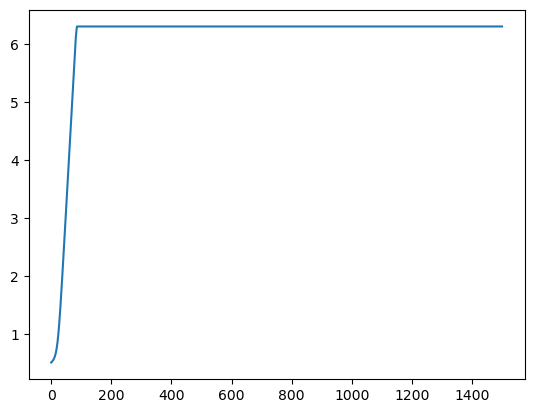

In [ ]:
N = MultiClassNN([1,2,3], CE_loss, CE_and_softmax_loss_derivative)

print(N.apply([150]))

avg_cost_func = N.train(new_data_x.reshape(-1, 1), new_data_target.reshape(-1, 1), 1500, 0.1)

sns.lineplot(data=avg_cost_func)
# get the prediction accuracy and print
predictions = [N.apply([10]), N.apply([260]),N.apply([140])]
print(predictions)
# print('LinearLayer', '\n', input_size, '\n', output_size, '\n', self.W, '\n', self.b, '\n', self.grad_W, '\n', self.grad_b)

Ничего не получилось? Не удивляйтесь, дело в том, что у наших данных достаточно большой разброс и они принимают достаточно большие значения, которые после прохождения через сигмоиду все становятся близки к 1.

In [25]:
print(sigmoid(1), sigmoid(5), sigmoid(10), sigmoid(99), sigmoid(199), sigmoid(299))

0.7310585786300049 0.9933071490757153 0.9999546021312976 1.0 1.0 1.0


Давайте теперь нормализуем наши данные — значения x переведем в диапазон [0,1].

In [26]:
new_data_x = np.random.randint(1, 300, 200)
new_data_target = new_data_x // 100
print(new_data_target)
new_data_x = new_data_x / 300   
print(new_data_x)

[1 1 1 2 2 0 0 1 2 0 1 0 1 0 2 0 2 0 0 1 0 1 2 0 2 0 2 2 0 2 0 1 0 0 0 0 1
 0 1 1 0 1 2 0 2 2 2 2 2 2 0 2 0 2 2 1 0 0 2 0 2 0 0 2 1 1 1 1 1 0 1 1 0 1
 1 1 1 2 2 2 2 2 1 1 0 1 2 1 2 2 1 0 2 2 1 1 1 2 0 0 0 0 0 1 1 0 2 2 0 1 1
 2 2 2 2 1 0 1 2 2 1 2 2 2 2 2 0 1 2 0 0 1 1 2 0 1 1 0 1 1 2 2 2 1 2 1 2 1
 1 2 2 1 2 0 2 0 1 2 0 0 0 1 1 2 0 2 0 2 0 0 0 1 1 2 2 1 0 0 2 0 0 2 2 2 2
 0 1 1 1 1 1 1 0 1 0 0 2 2 2 1]
[0.44       0.46666667 0.61666667 0.71333333 0.83333333 0.04333333
 0.18666667 0.46333333 0.92333333 0.31666667 0.61666667 0.2
 0.52333333 0.29333333 0.69333333 0.15       0.94       0.05
 0.06666667 0.59       0.13333333 0.64666667 0.85333333 0.23
 0.78       0.09333333 0.96333333 0.98666667 0.31       0.94333333
 0.20666667 0.37666667 0.04666667 0.19666667 0.25333333 0.23333333
 0.54666667 0.18       0.49       0.38666667 0.04333333 0.63666667
 0.85       0.06666667 0.72       0.94       0.80666667 0.75333333
 0.98       0.88       0.05666667 0.94333333 0.25       0.76
 0.87333333 0.6

In [34]:
N = MultiClassNN([1,2,3], CE_loss, CE_and_softmax_loss_derivative)

print(N.apply([0.1]))

avg_cost_func = N.train(new_data_x.reshape(-1, 1), new_data_target.reshape(-1, 1), 1500, 0.1)

sns.lineplot(data=avg_cost_func)
# get the prediction accuracy and print
predictions = [N.apply([0.2]), N.apply([0.6]),N.apply([0.9])]
print(predictions)

[0.28034928 0.34961998 0.37003074]


 14%|█▎        | 205/1500 [02:00<12:39,  1.70it/s]  


KeyboardInterrupt: 

Теперь наша сеть действительно научилась отделять числа на числовой прямой. Только нужно не забывать о том, что и данные ей теперь всегда нужно давать нормализованные.

# Обучение сети на Digits

Давайте попробуем нашу сеть на чем-то более серьезном.

Возьмем датасет Digits — он представляет собой изображения рукописных чисел размером 8х8 пикселей.

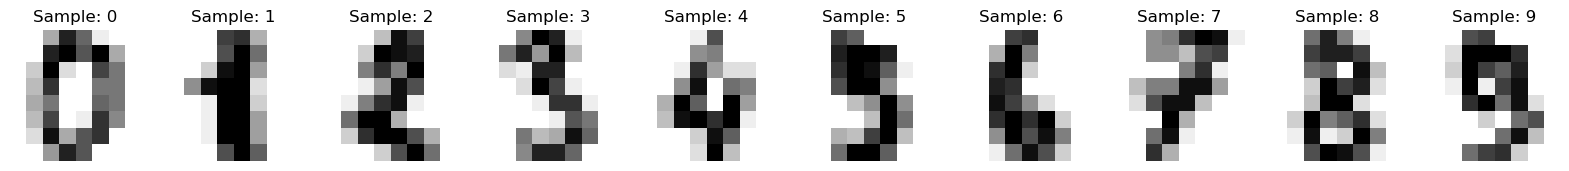

In [28]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Sample: %i' % label)

Мы реализовали только линейный слой, а он не может принимать на вход двумерные изображения.

Но есть выход, давайте разложим двумерную матрицу изображения в одномерный вектор, для этого воспользуемся функцией reshape, вам нужно только выбрать правильный размер.

In [29]:
n_samples = len(digits.images)
data = digits.images.reshape((len(digits.images), -1)) 
print(data.shape)

# эта функция поможет разбить наш датасет на обучающую и тестовые выборки случайным образом
# data/16 — это нормализация

X_train, X_test, y_train, y_test = train_test_split(
    data/16, digits.target, test_size=0.3, shuffle=False)

print(X_train.shape, y_train.reshape(-1, 1).shape)
#(1257, 64) (1257, 1)

(1797, 64)
(1257, 64) (1257, 1)


Выберите структуру сети сами. Важно указать правильно входной и выходные размеры — размер вектора картинки и количество различных цифр в нашем датасете.

Также предлагаем вам подобрать количество итераций и learning rate.

100%|██████████| 500/500 [01:36<00:00,  5.17it/s]


<AxesSubplot:>

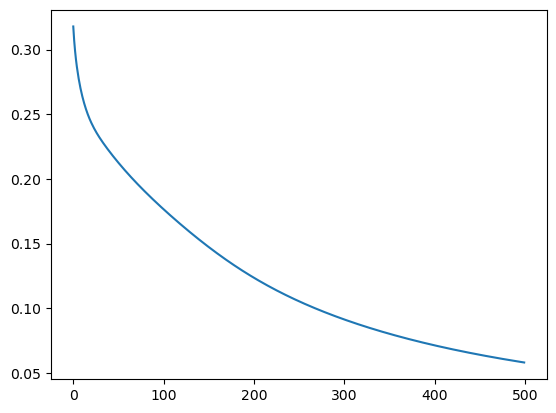

In [36]:
structure = [64, 32, 10]

iter_num = 500

lr = 0.1

N = MultiClassNN(structure, CE_loss, CE_and_softmax_loss_derivative)

avg_cost_func = N.train(X_train, y_train.reshape(-1, 1), iter_num, lr)

sns.lineplot(data=avg_cost_func)

Проверим на каком-нибудь примере, как всё работает.

In [37]:
predictions = N.apply(X_train[1])
print(predictions)

[0.00080885 0.79180975 0.05300913 0.00873744 0.03858371 0.0029494
 0.00764042 0.02482777 0.05719677 0.01443676]


Теперь посчитаем точность вашей сети:

In [38]:
def estimate_accuracy(predictions, targets):
    sum = 0
    for i in range(len(predictions)):
        if predictions[i] == targets[i]:
            sum += 1
    return sum/len(predictions)
        

In [39]:
train_preds = np.array([N.apply(x).argmax() for x in X_train])
print("train accuracy = {}".format(estimate_accuracy(train_preds, y_train)))

test_preds = np.array([N.apply(x).argmax() for x in X_test])
print("test accuracy = {}".format(estimate_accuracy(test_preds, y_test)))

train accuracy = 0.9284009546539379
test accuracy = 0.8481481481481481


Задание считается выполненным, если test_accuracy >= 0.8.